In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv', index_col='Unnamed: 0')

In [32]:
from ModelTesters.BaselineModelTester import BaselineModelTester
from utils.ErrorMetrics import calculate_all_errors

## Random Walk on each dataset

In [33]:
class RandomWalk():
    
    def __init__(self, horizon):
        self.horizon = horizon
    
    def fit(self, train, labels):
        self.train = labels
    
    def predict(self, data):
        comb_data = np.hstack([self.train, data])
        
        results = np.zeros((len(data), self.horizon))
        
        std = np.std(comb_data)
        
        results[:, 0] = data[:]
        
        noise = np.random.normal(0, std, (len(data), self.horizon))
        results += noise        
        
        return results.cumsum(axis=1)
    
    def __repr__(self):
        return 'Random Walk'

In [34]:
walk = RandomWalk(5)

In [35]:
d = np.arange(0, 100)

In [36]:
walk.fit(d[:80], d[:80])

In [37]:
a = walk.predict(d[80:])

Text(0.5,1,'Random Walk')

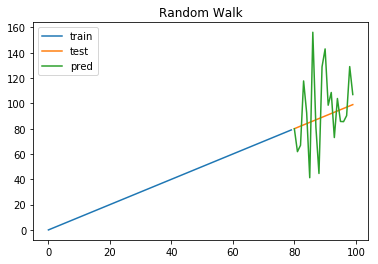

In [38]:
%matplotlib inline
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])
plt.legend(['train', 'test', 'pred'])
plt.title('Random Walk')

## Mean estimation

In [39]:
class MeanEstimator():
    
    def __init__(self, horizon):
        self.horizon = horizon
        
    def fit(self, train, labels):
        self.train = labels
    
    def predict(self, data):
        return np.repeat( pd.Series(np.hstack([self.train, data])).expanding().mean()[len(self.train):], self.horizon).values.reshape(len(data), self.horizon)    

    def __repr__(self):
        return 'Mean Estimator'

In [40]:
me = MeanEstimator(5)

In [41]:
d = np.arange(0, 100)

In [42]:
me.fit(d[:80], d[:80])

In [43]:
a = me.predict(d[80:])

Text(0.5,1,'Mean estimator')

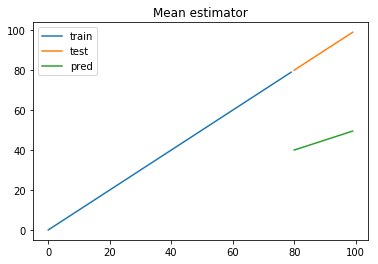

In [44]:
%matplotlib inline
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])
plt.legend(['train', 'test', 'pred'])
plt.title('Mean estimator')

## Moving Average Estimator

In [45]:
class MovingAvgEstimator():
    
    def __init__(self, horizon, back_horizon=None):
        self.horizon = horizon
        
        if back_horizon is None:
            back_horizon = horizon
        self.back_horizon = back_horizon
        
    def fit(self, train, labels):
        self.starting_horizon = labels[-(self.back_horizon - 1):]
        
    def predict(self, data):
        comb_data = np.hstack([self.starting_horizon, data])
        
        return np.repeat(pd.Series(comb_data).rolling(self.back_horizon).mean().dropna(axis=0).values, self.horizon).reshape(len(data), self.horizon)
    
    def __repr__(self):
        return 'Moving Avg Estimator: (h={:d})'.format(self.horizon)

In [46]:
mva = MovingAvgEstimator(5, 30)

In [47]:
d = np.arange(0, 100)
rand = 1.0 * np.random.randn(100) + 0
rand = np.cumsum(rand)

In [48]:
mva.fit(d[:80], d[:80])

In [49]:
a = mva.predict(d[80:])

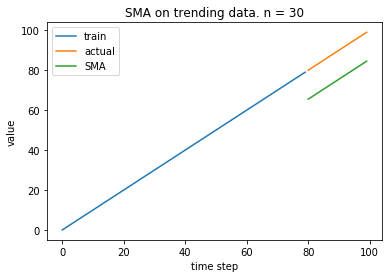

In [50]:
%matplotlib inline
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])

plt.xlabel('time step')
plt.ylabel('value')
plt.title('SMA on trending data. n = 30')
plt.legend(['train', 'actual', 'SMA'])

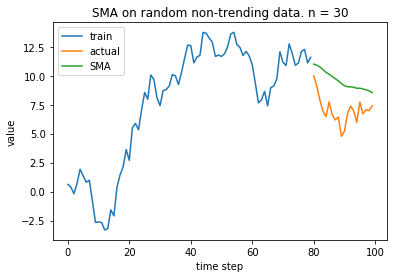

In [51]:
# On random data
mva = MovingAvgEstimator(5, 30)
mva.fit(rand[:80], rand[:80])
a = mva.predict(rand[80:])

%matplotlib inline
plt.plot(np.arange(80), rand[:80])
plt.plot(np.arange(80, 100), rand[80:])
plt.plot(np.arange(80, 100), a[:, 1])

plt.xlabel('time step')
plt.ylabel('value')
plt.title('SMA on random non-trending data. n = 30')
plt.legend(['train', 'actual', 'SMA'])

In [52]:
"""
Use to increase the prediction speed.
tester -> Tester class that implements the BaseModelTester class
data -> A pandas dataframe with columns as each dataset and rows as each sample
horizon -> The number of periods to predict ahead
"""
def speed_up_calc(tester, data, horizon):
    # Loading bar
    tester.progressBar.set_length(len(data.columns))

    # walk speed up
    for i, column in enumerate(data.columns):
        # Split into train and test data
        split = int(0.20 * len(data))
        train, test = data[column][:split].values, data[column][split:].values
        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]

        tester.model.fit(train, train)
        pred = tester.model.predict(test)
        tester.predictions[column] = pred

        errors = {}
        for key, value in calculate_all_errors(train, test, pred, horizon).items():
            errors[key] = [value]

        t = pd.DataFrame.from_dict(errors)
        t.set_index(keys=[[column]], inplace=True)
        tester.errors = tester.errors.append(t)

        tester.progressBar.progress()

# Forecasting

## 1 minute horizon

In [57]:
horizon = 1

one_min_walk = RandomWalk(horizon)
one_min_mean = MeanEstimator(horizon)
one_min_mva = MovingAvgEstimator(horizon, 15)

#### Random walk at 1 minute

In [58]:
one_min_walk_tester = BaselineModelTester(data, one_min_walk, horizon, 0.20)
speed_up_calc(one_min_walk_tester, data, horizon)

Progress: [####################] 100.0%


In [59]:
one_min_walk_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE
window_1_0,295.776758,371.752745,673.877657,105.025673,1.243671,10.672481,10.672481,1.003770
window_1_1,304.128614,380.829010,939.241402,106.498372,1.510055,11.055229,11.055229,1.018441
window_1_2,343.412338,430.468933,779.802009,108.285663,1.109171,8.648980,8.648980,1.055688
window_1_3,385.045572,482.345792,495.775081,102.550317,0.985798,8.890877,8.890877,1.000270
window_1_4,334.981519,419.038913,3114.094384,116.898613,1.118640,7.055745,7.055745,1.160622


Text(0.5,1,'RMSE vs H for random walk at 1 minute horizon')

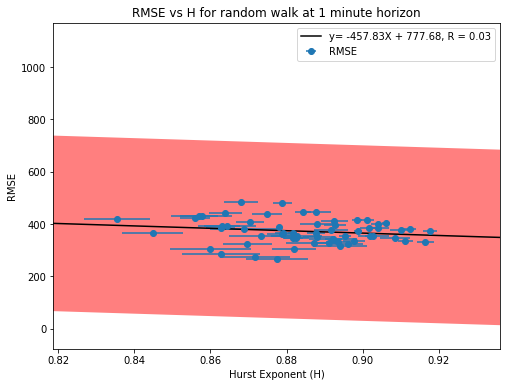

In [60]:
%matplotlib inline
one_min_walk_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for random walk at 1 minute horizon')

Text(0.5,1,'MASE vs H for random walk at 1 minute horizon')

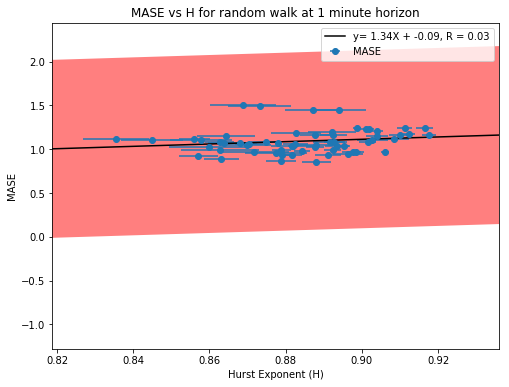

In [61]:
%matplotlib inline
one_min_walk_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for random walk at 1 minute horizon')

In [ ]:
# Save the results to a csv
one_min_walk_tester.errors.to_csv('results/one_minute_random_walk_results.csv')

#### Mean Estimator at 1 minute

In [62]:
one_min_mean_tester = BaselineModelTester(data, one_min_mean, horizon, 0.20)
speed_up_calc(one_min_mean_tester, data, horizon)

Progress: [####################] 100.0%


In [63]:
one_min_mean_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE
window_1_0,294.708267,383.840209,100.394376,198.038759,1.239178,10.633927,10.633927,1.000144
window_1_1,298.553692,396.919130,102.295595,198.005408,1.482374,10.852578,10.852578,0.999772
window_1_2,325.316326,427.998295,100.834025,197.182665,1.050724,8.193224,8.193224,1.000058
window_1_3,384.556657,474.143761,100.827081,196.979884,0.984546,8.879588,8.879588,0.999000
window_1_4,288.599218,414.853780,106.940037,195.603028,0.963750,6.078790,6.078790,0.999920


(-50, 800)

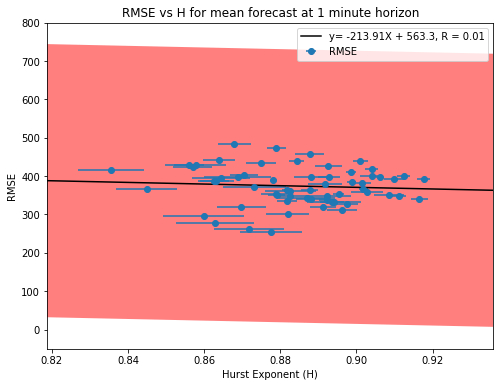

In [64]:
one_min_mean_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for mean forecast at 1 minute horizon')
plt.ylim([-50, 800])

Text(0.5,1,'MASE vs H for mean forecast at 1 minute horizon')

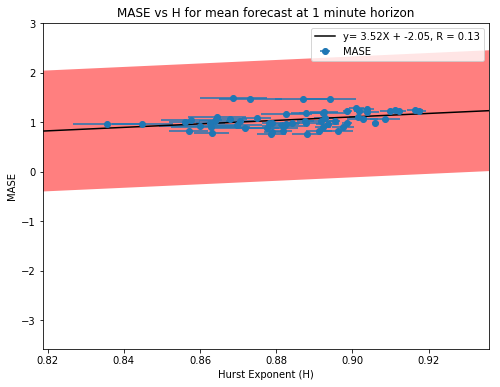

In [65]:
one_min_mean_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for mean forecast at 1 minute horizon')

In [131]:
one_min_mean_tester.errors.to_csv('results/one_minute_mean_results.csv')

#### Moving Average at 1 minute

In [66]:
one_min_mva_tester = BaselineModelTester(data, one_min_mva, horizon, 0.20)
speed_up_calc(one_min_mva_tester, data, horizon)

Progress: [####################] 100.0%


(-0.3, 0.9)

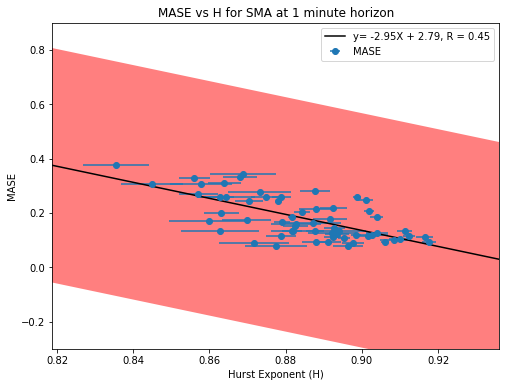

In [67]:
one_min_mva_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for SMA at 1 minute horizon')
plt.ylim([-0.3, 0.9])

Text(0.5,1,'RMSE vs H for SMA at 1 minute horizon')

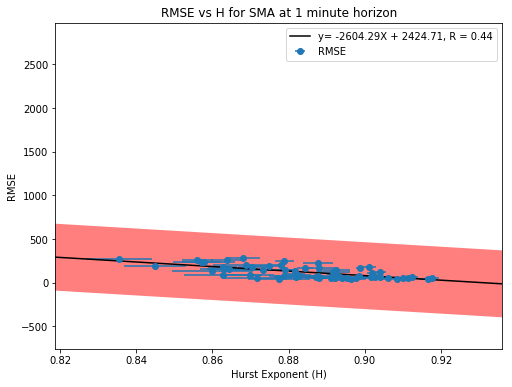

In [68]:
one_min_mva_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for SMA at 1 minute horizon')

one_min_mva_tester.errors.head()

In [133]:
one_min_mva_tester.errors.to_csv('results/one_minute_mva_results.csv')

## 5 Minute horizon

In [32]:
horizon = 5

five_min_walk = RandomWalk(horizon)
five_min_mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 30)

In [36]:
five_min_walk_tester = BaselineModelTester(data, five_min_walk, horizon, 0.20)
speed_up_calc(five_min_walk_tester, data, horizon)

Progress: [####################] 100.0%


In [37]:
five_min_walk_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,508.817749,660.687332,1132.626066,125.529012,2.139458,1596.66458,1.726684
window_1_1,519.073401,676.043580,2372.511665,126.081100,2.577295,597.30778,1.738174
window_1_2,592.958742,772.981916,1431.077783,128.179499,1.915169,-412.99287,1.822795
window_1_3,657.990289,856.424156,875.731673,123.075489,1.684594,301.25757,1.709418
window_1_4,580.402226,757.443263,3904.591805,135.247873,1.938200,815.84371,2.011100


(-0.5, 4)

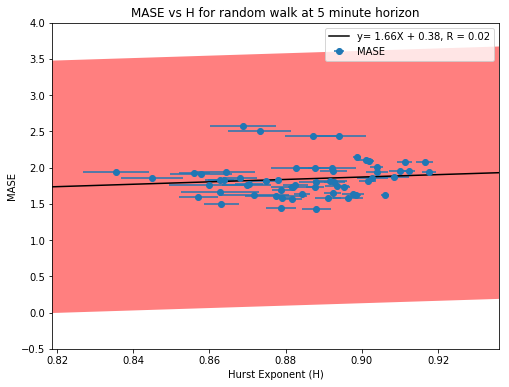

In [76]:
five_min_walk_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for random walk at 5 minute horizon')
plt.ylim([-0.5, 4])

In [136]:
five_min_walk_tester.errors.to_csv('results/five_minute_random_walk_results.csv')

In [72]:
five_min_mean_tester = BaselineModelTester(data, five_min_mean, horizon, 0.20)
speed_up_calc(five_min_mean_tester, data, horizon)

Progress: [####################] 100.0%


In [73]:
five_min_mean_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,294.735580,383.871506,100.398976,198.047930,1.239293,924.87705,1.000191
window_1_1,298.577213,396.950630,102.300430,198.014429,1.482491,343.57856,0.999819
window_1_2,325.335164,428.026491,100.837619,197.191832,1.050784,-226.59436,1.000102
window_1_3,384.552813,474.147254,100.831235,196.989060,0.984537,176.06559,0.999044
window_1_4,288.589003,414.849820,106.944517,195.611052,0.963716,405.65579,0.999964


(-0.5, 800)

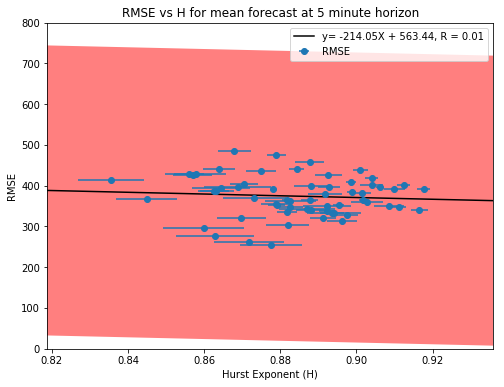

In [81]:
five_min_mean_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for mean forecast at 5 minute horizon')
plt.ylim([-0.5, 800])

In [137]:
five_min_mean_tester.errors.to_csv('results/five_minute_mean_results.csv')

In [33]:
five_min_mva_tester = BaselineModelTester(data, mva, horizon, 0.20)
speed_up_calc(five_min_mva_tester, data, horizon)

Progress: [####################] 100.0%


In [34]:
five_min_mva_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE
window_1_0,92.004262,208.059042,115.133188,37.537537,0.386856,2.802512,2.802512,0.312218
window_1_1,99.286771,251.944313,94.859098,34.478342,0.492977,2.959562,2.959562,0.332473
window_1_2,130.370188,286.018674,161.372089,43.063600,0.421076,2.675044,2.675044,0.400767
window_1_3,139.142118,298.247507,118.738351,41.153721,0.356233,2.645821,2.645821,0.361483
window_1_4,151.932361,327.763359,342.077881,49.662307,0.507364,2.614992,2.614992,0.526447


Text(0.5,1,'MASE vs H for MVA at 5 minute horizon')

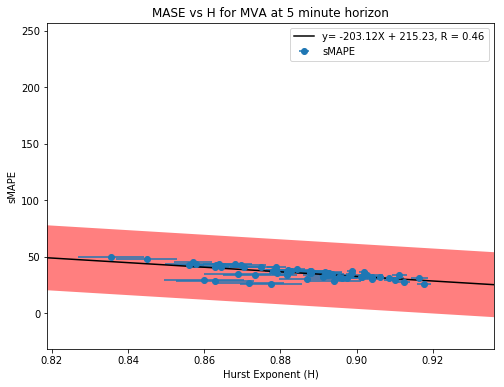

In [45]:
five_min_mva_tester.compare_hurst(hurst_estimates, err_to_use='sMAPE')
plt.title('MASE vs H for MVA at 5 minute horizon')
# plt.ylim([-0.3, 1.0])

In [138]:
five_min_mva_tester.errors.to_csv('results/five_minute_mva_results.csv')

## 60 minute horizon

In [53]:
horizon = 60

sixty_min_walk = RandomWalk(horizon)
sixty_min_mean = MeanEstimator(horizon)
sixty_min_mva = MovingAvgEstimator(horizon, 45)

In [50]:
sixty_min_walk_tester = BaselineModelTester(data, sixty_min_walk, horizon, 0.20)
speed_up_calc(sixty_min_walk_tester, data, horizon)

Progress: [####################] 100.0%


In [51]:
sixty_min_walk_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,1572.342579,2080.233241,3581.049307,158.137552,6.611327,4933.99397,5.333907
window_1_1,1608.030944,2129.054410,6792.601899,158.718329,7.984171,1850.39223,5.382880
window_1_2,1823.101337,2413.247378,4432.242017,160.064869,5.888348,-1269.78120,5.602921
window_1_3,2034.676306,2691.361286,2822.031044,157.181251,5.209202,931.56640,5.289229
window_1_4,1777.254558,2351.785944,14096.987373,164.417816,5.934978,2498.20191,6.159889


(0, 4500)

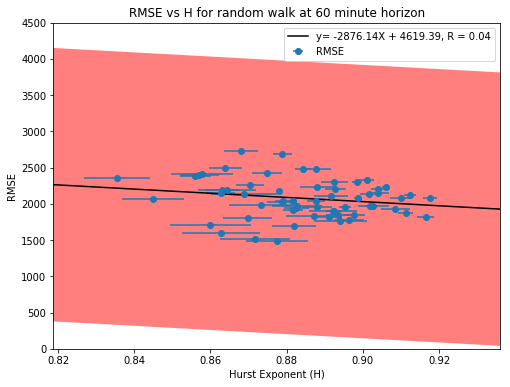

In [56]:
sixty_min_walk_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for random walk at 60 minute horizon')
plt.ylim([0, 4500])

In [139]:
sixty_min_walk_tester.errors.to_csv('results/sixty_minute_random_walk_results.csv')

In [107]:
sixty_min_mean_tester = BaselineModelTester(data, sixty_min_mean, horizon, 0.20)
speed_up_calc(sixty_min_mean_tester, data, horizon)

Progress: [####################] 100.0%


In [108]:
sixty_min_mean_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,295.001364,384.186327,100.450509,198.177185,1.240411,925.71108,1.000742
window_1_1,298.831773,397.267062,102.366094,198.137860,1.483755,343.87149,1.000339
window_1_2,325.561436,428.307949,100.896857,197.306237,1.051515,-226.75195,1.000545
window_1_3,384.494467,474.092346,100.883576,197.099311,0.984387,176.03887,0.999510
window_1_4,288.611209,414.884364,107.109562,195.693513,0.963791,405.68700,1.000314


(-0.6, 2.7)

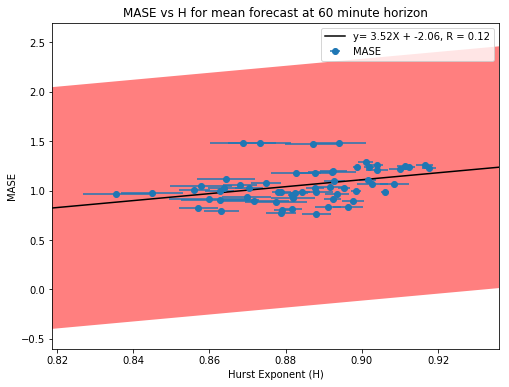

In [116]:
sixty_min_mean_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for mean forecast at 60 minute horizon')
plt.ylim([-0.6, 2.7])

In [140]:
sixty_min_mean_tester.errors.to_csv('results/sixty_minute_mean_results.csv')

In [54]:
sixty_min_mva_tester = BaselineModelTester(data, sixty_min_mva, horizon, 0.20)
speed_up_calc(sixty_min_mva_tester, data, horizon)

Progress: [####################] 100.0%


(-0.2, 1.4)

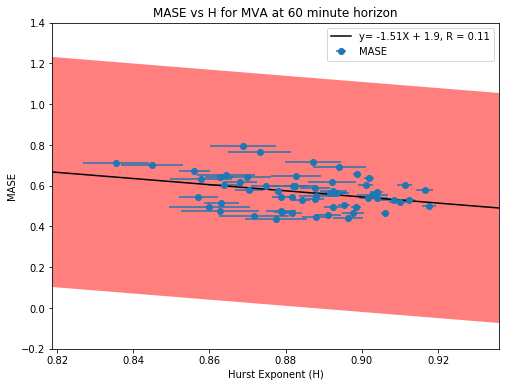

In [73]:
sixty_min_mva_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for MVA at 60 minute horizon')
plt.ylim([-0.2, 1.4])

In [62]:
sixty_min_mva_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,92.004262,208.059042,115.133188,37.537537,0.386856,288.70838,0.312218
window_1_1,99.286771,251.944313,94.859098,34.478342,0.492977,114.25120,0.332473
window_1_2,130.370188,286.018674,161.372089,43.063600,0.421076,-90.80220,0.400767
window_1_3,139.142118,298.247507,118.738351,41.153721,0.356233,63.70552,0.361483
window_1_4,151.932361,327.763359,342.077881,49.662307,0.507364,213.56407,0.526447


In [141]:
sixty_min_mva_tester.errors.to_csv('results/sixty_minute_mva_results.csv')